In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [154]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from random import randrange
from sklearn.model_selection import train_test_split as tts,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor as dt
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error,make_scorer,f1_score,r2_score,mean_absolute_error

In [17]:
housing=pd.read_csv('/content/drive/MyDrive/Data_PRML/Housing.csv')

In [18]:
cat_feature=list(housing.select_dtypes(include=['object']).columns)
for feature in cat_feature:
    feature_value=list(housing[feature].unique())
    for val in feature_value:
        housing.loc[housing[feature]==val,feature]=feature_value.index(val)
housing.head()        

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,0,0,0,0,0,2,0,0
1,12250000,8960,4,4,4,0,0,0,0,0,3,1,0
2,12250000,9960,3,2,2,0,0,1,0,1,2,0,1
3,12215000,7500,4,2,2,0,0,1,0,0,3,0,0
4,11410000,7420,4,1,2,0,1,1,0,0,2,1,0


In [136]:
user_prompt = 0.3
user_enable = True
Y=housing['price']
X=housing[['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']]
X_train,X_test,y_train,y_test = tts(X,Y,test_size=user_prompt,shuffle=user_enable)

In [137]:
mode=dt(max_depth=3)
mode.fit(X_train,y_train)
y_prif=mode.predict(X_test)
print(r2_score(y_test,y_prif))

0.44105016991067114


In [72]:
def R2_score(y_pred,y_test):
  Mean=y_test.mean()
  E1=0
  for i in range(len(y_pred)):
    E1=E1+(y_pred[i]-y_test[i])**2
  E2=0
  for i in y_pred:
    E2=E2+(i-Mean)**2
  return 1-(E1/E2)   

In [73]:
def splitting_into_kfold(x,y,n_fold):
  final=[]
  prefinal=[]
  Length_of_fold=round(x.shape[0]/n_fold)
  x_copy=x
  y_copy=y
  for i in range(n_fold):
    fold=[]
    told=[]
    while(len(fold)<Length_of_fold):
      r=randrange(x_copy.shape[0])
      index = x_copy.index[r]
      fold.append(x_copy.loc[index].tolist())
      told.append(y_copy.loc[index].tolist())
      x_copy = x_copy.drop(index)
      y_copy = y_copy.drop(index)
    final.append(np.asarray(fold))
    prefinal.append(np.array(told))
  return final,prefinal

In [74]:
def Cross_val_score(model,x,y,n):
  data_x,data_y=splitting_into_kfold(x,y,n)
  result=[]
  for i in range(n):
      r = list(range(n))
      test=data_x[i]
      r.pop(i)
      for j in r :
          if j == r[0]:
              cv_1 = data_x[j]
              cv_2=data_y[j]
          else:    
              cv_1=np.concatenate((cv_1,data_x[j]), axis=0)
              cv_2=np.concatenate((cv_2,data_y[j]), axis=0)

      moel.fit(cv_1,cv_2)
      prediction=moel.predict(test)
      result.append(r2_score(prediction,data_y[i]))
  return np.asarray(result) 
    

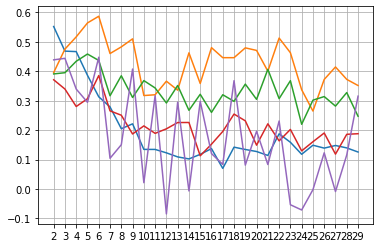

In [182]:
data_x,data_y=splitting_into_kfold(X_train,y_train,5)
result=[]
L=[]
for i in range(5):
    r = list(range(5))
    test_x=data_x[i]
    test_y=data_y[i]
    r.pop(i)
    for j in r :
        if j == r[0]:
          cv_1 = data_x[j]
          cv_2=data_y[j]
        else:    
          cv_1=np.concatenate((cv_1,data_x[j]), axis=0)
          cv_2=np.concatenate((cv_2,data_y[j]), axis=0)
    for j in range(2,30,1):
      moel=dt(max_depth=j)                      
      moel.fit(cv_1,cv_2)
      prediction=moel.predict(test_x)
      L.append(r2_score(test_y,prediction))
      #result.append(r2_score(data_y[i],prediction))

    op=[i for i in range(2,30,1)]
    # plt.figure(figsize=(15,5))
    plt.plot(op,L)
    plt.xticks(op)
    plt.grid()
    L=[]  

In [77]:
def cross_validation_on_tree(x,y,cv=5):
  cv_score=[]
  cv_score_mean=[]
  cv_score_sd=[]
  max_depth=[i for i  in range(2,30,1)]
  for depth in max_depth:
    mdel=dt(max_depth=depth)
    mdel.fit(x,y)
    cv_score=Cross_val_score(mdel,x,y,5)
    cv_score_mean.append(cv_score.mean())
    cv_score_sd.append(cv_score.std())
  return cv_score_mean,cv_score_sd

def graph_cv(cv_mean_list,cv_std_list,depth):
  plt.figure(figsize=(15,5))
  plt.plot(depth,cv_mean_list,'-o')
  plt.xticks(depth)
  plt.xlabel("Depth",fontsize=14)
  plt.ylabel("r2 score",fontsize=14)
  plt.grid()
  plt.show()

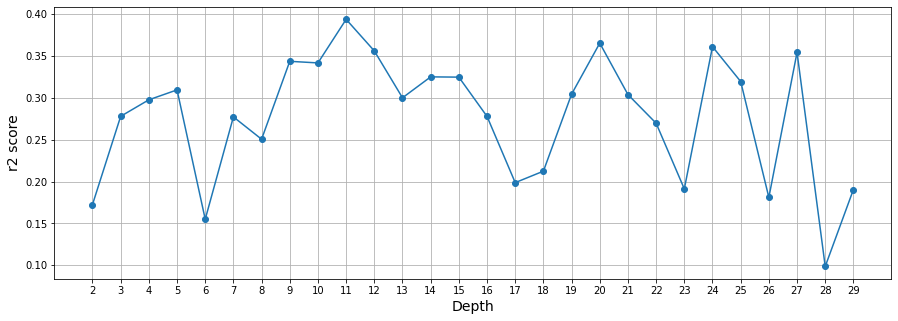

11

In [78]:
cv_score_mean,cv_score_std=cross_validation_on_tree(X_train,y_train)
depth=[i for i in range(2,30,1)]
graph_cv(cv_score_mean,cv_score_std,depth)
depth[cv_score_mean.index(max(cv_score_mean))]

In [177]:
class Bagger_decision_tree:

  def __init__(self,n_estimators):
    self.trees=n_estimators

  def Fit(self,depth,x,y,xtest,ytest):
    self.models=[]
    for i in range(self.trees):
      index=np.random.choice(x.shape[0],size=x.shape[0])
      X_1_train=x.iloc[index]
      Y_1_train=y.iloc[index]  
      model=dt(max_depth=depth)
      model.fit(X_1_train,Y_1_train)
      self.models.append(model)
      W=[]
      for j in range(2,30,1):
        h=dt(max_depth=j)
        h.fit(X_1_train,Y_1_train)
        P=h.predict(xtest)
        W.append(r2_score(ytest,P))
      plt.figure(figsize=(15,5))  
      plt.plot([k for k in range(2,30,1)],W)
      plt.xticks([k for k in range(2,30,1)])
      plt.grid()
      plt.show()

  def Predict(self,x):
    pred=np.zeros(x.shape[0]) 
    for model in self.models:
       
      pred=pred+(model.predict(x))
        
    return np.round((pred)/self.trees)  

  def acc(self,x,y_true,y_pred):
    return r2_score(y_true,y_pred)    

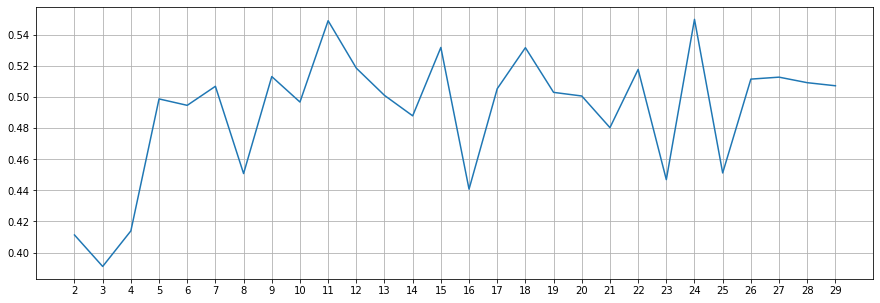

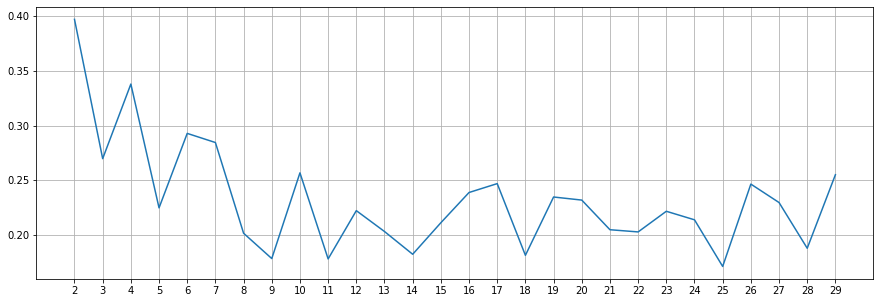

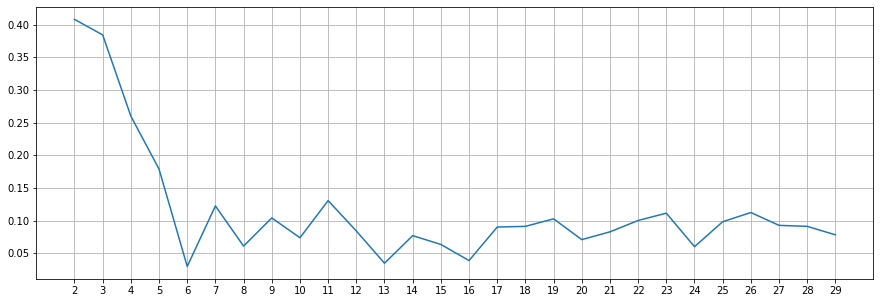

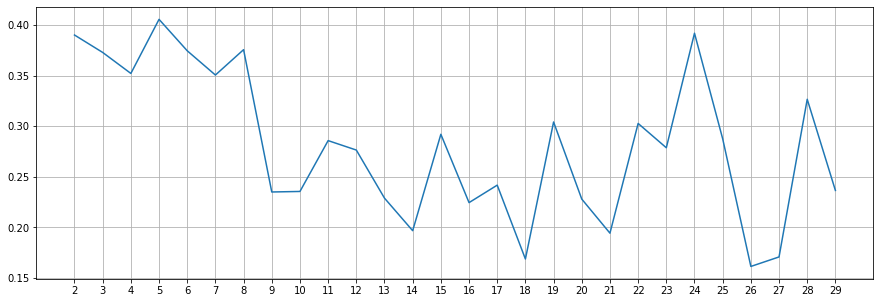

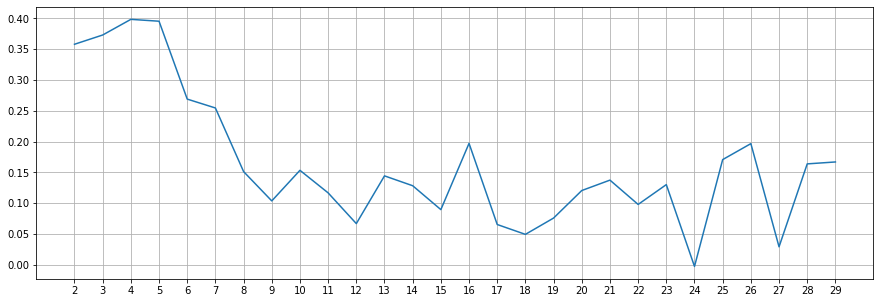

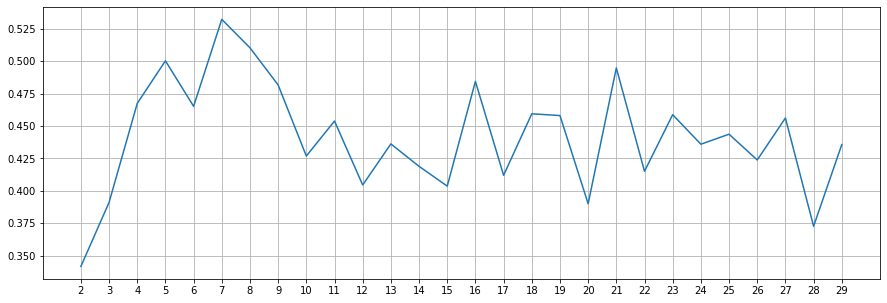

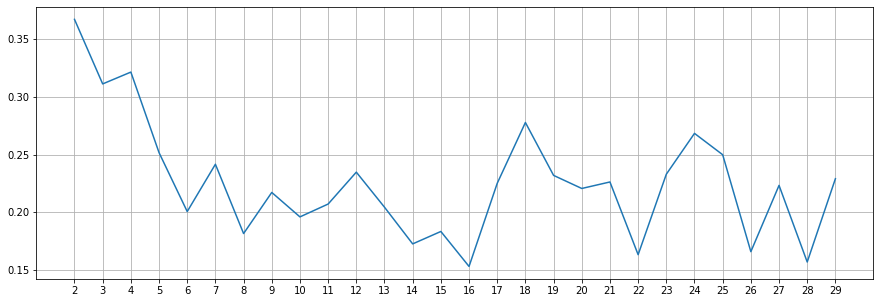

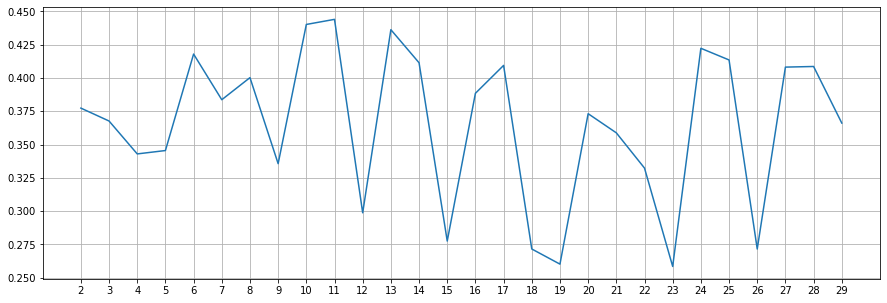

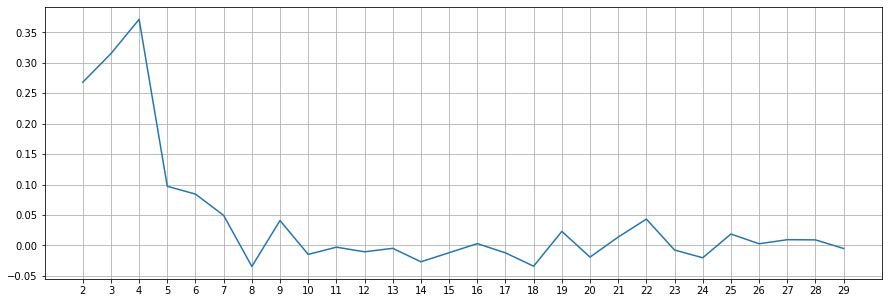

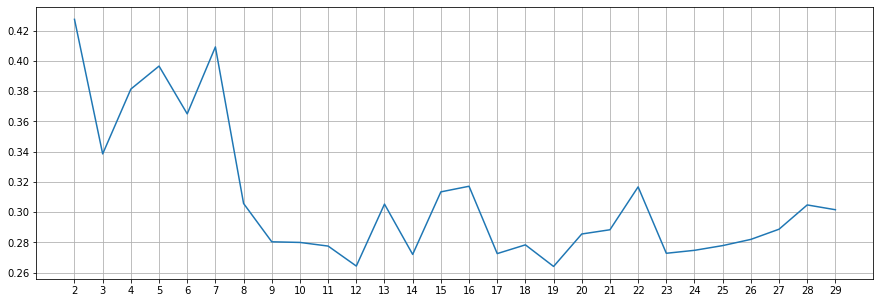

0.5044527458914387

In [178]:
my_tree=Bagger_decision_tree(10)
my_tree.Fit(3,X_train,y_train,X_test,y_test)
y_pred=my_tree.Predict(X_test)
L=y_test.to_numpy()
my_tree.acc(X_test,L,y_pred)

In [179]:
depth=[i for i in range(3,30,1)]
w=[]
for i in depth:
  fict=Bagger_decision_tree(10)
  fict.Fit(i,X_train,y_train,X_test,y_test)
  w.append(r2_score(y_test,fict.Predict(X_test)))
plt.plot(depth,w,'g')
plt.xticks(depth)
plt.grid()
plt.show()


depth=[i for i in range(1,4,1)]
w=[]
for i in depth:
  fict=Bagger_decision_tree(10)
  fict.Fit(i,X_train,y_train,X_test,y_test)
  w.append(r2_score(y_test,fict.Predict(X_test)))
plt.plot(depth,w,'g')
plt.xticks(depth)
plt.grid()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [155]:
from sklearn.ensemble import RandomForestRegressor as RF
Ti=RF(n_estimators = 10, random_state = 0)
Ti.fit(X_train,y_train)
y_op=Ti.predict(X_test)
print(mean_squared_error(L,y_op))
print(mean_absolute_error(L,y_op))


1517850032465.8706
875652.5508130082


In [161]:
from sklearn.ensemble import AdaBoostRegressor as FT
Ti=FT(n_estimators = 10, random_state = 0)
Ti.fit(X_train,y_train)
y_op=Ti.predict(X_test)
print(mean_squared_error(L,y_op))
print(mean_absolute_error(L,y_op))
print(r2_score(y_test,y_op))

1784565166409.6265
942731.0502584697
0.5457483826978687
